In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [4]:
train['income']=pd.factorize(train['income'], sort=True)[0]

In [5]:
train.shape, test.shape

((26049, 15), (6512, 14))

In [6]:
train.head(3)
train.tail(3)
test.head(3)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
id,,,,,,,,,,,,,,,
0,40,Private,168538,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,1
1,17,Private,101626,9th,5,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,20,United-States,0
2,18,Private,353358,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,16,United-States,0


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
id,,,,,,,,,,,,,,,
26046,78,?,165694,Masters,14,Widowed,?,Not-in-family,White,Female,0,0,15,United-States,0
26047,26,Self-emp-not-inc,151626,HS-grad,9,Never-married,Prof-specialty,Own-child,Black,Female,0,0,40,United-States,0
26048,20,?,99891,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
id,,,,,,,,,,,,,,
0,28,Private,67661,Some-college,10,Never-married,Adm-clerical,Other-relative,White,Female,0,0,40,United-States
1,40,Self-emp-inc,37869,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
2,20,Private,109952,Some-college,10,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,25,United-States


# 2. EDA & 전처리

In [7]:
train.info()
train.describe()
train.describe(include='O')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26049 entries, 0 to 26048
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             26049 non-null  int64 
 1   workclass       26049 non-null  object
 2   fnlwgt          26049 non-null  int64 
 3   education       26049 non-null  object
 4   education_num   26049 non-null  int64 
 5   marital_status  26049 non-null  object
 6   occupation      26049 non-null  object
 7   relationship    26049 non-null  object
 8   race            26049 non-null  object
 9   sex             26049 non-null  object
 10  capital_gain    26049 non-null  int64 
 11  capital_loss    26049 non-null  int64 
 12  hours_per_week  26049 non-null  int64 
 13  native_country  26049 non-null  object
 14  income          26049 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.2+ MB


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income
count,26049.000000,2.604900e+04,26049.000000,26049.00000,26049.000000,26049.000000,26049.000000
mean,38.569235,1.903045e+05,10.088372,1087.68970,87.732734,40.443126,0.242044
std,13.671489,1.059663e+05,2.567610,7388.85469,403.230205,12.361850,0.428329
min,17.000000,1.376900e+04,1.000000,0.00000,0.000000,1.000000,0.000000
25%,28.000000,1.181080e+05,9.000000,0.00000,0.000000,40.000000,0.000000
50%,37.000000,1.788660e+05,10.000000,0.00000,0.000000,40.000000,0.000000
75%,48.000000,2.377350e+05,12.000000,0.00000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.00000,4356.000000,99.000000,1.000000


,workclass,education,marital_status,occupation,relationship,race,sex,native_country
count,26049,26049,26049,26049,26049,26049,26049,26049
unique,9,16,7,15,6,5,2,41
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,18123,8433,11970,3304,10541,22315,17482,23371


## Missing Value

In [8]:
train.isnull().sum().sum()
test.isnull().sum().sum()

0

0

### outlier

### education

In [9]:
train.drop(['education'],axis=1, inplace=True)
test.drop(['education'],axis=1, inplace=True)

### capital_gain 99999

In [10]:
df = pd.concat([train, test])
df['capital_gain_imsi'] = df['capital_gain'].replace(99999,0)
capital_gain_imsi = pd.DataFrame(df.groupby(['education_num'])['capital_gain_imsi'].mean()).reset_index()
train = train.merge(capital_gain_imsi, on=['education_num'], how='left')
test = test.merge(capital_gain_imsi, on=['education_num'], how='left')
train.loc[train.capital_gain == 99999, 'capital_gain'] = train['capital_gain_imsi']
test.loc[test.capital_gain == 99999, 'capital_gain'] = test['capital_gain_imsi']
train.drop(['capital_gain_imsi'],axis=1, inplace=True)
test.drop(['capital_gain_imsi'],axis=1, inplace=True)

In [11]:
train['capital'] = train['capital_gain'] - train['capital_loss']
test['capital'] = test['capital_gain'] - test['capital_loss']

# 3. 모델 학습

In [26]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'income'
          #, categorical_features=col_cat
          , numeric_features = ['education_num']
          , ignore_features = ['capital_gain','capital_loss']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(26049, 15)"
4,Missing Values,False
5,Numeric Features,7
6,Categorical Features,7
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 9.07 s


In [27]:
best_3 = compare_models(sort = 'F1', n_select = 3
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.8659,0.9209,0.6465,0.7635,0.7000,0.6144,0.6180,0.3051
1,Extreme Gradient Boosting,0.8649,0.9217,0.6484,0.7592,0.6992,0.6128,0.6162,2.0667
2,CatBoost Classifier,0.8659,0.9237,0.6335,0.7722,0.6956,0.6107,0.6159,11.1394
3,Gradient Boosting Classifier,0.8635,0.9177,0.6099,0.7784,0.6837,0.5984,0.6057,2.0419
4,Ada Boost Classifier,0.8574,0.9115,0.6180,0.7492,0.6771,0.5867,0.5913,0.7740
5,Linear Discriminant Analysis,0.8460,0.9000,0.5927,0.7216,0.6504,0.5529,0.5576,0.1856
6,Extra Trees Classifier,0.8394,0.8873,0.6070,0.6925,0.6466,0.5433,0.5455,0.5258
7,Random Forest Classifier,0.8470,0.8792,0.5691,0.7393,0.6428,0.5476,0.5554,0.1225


In [28]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8672,0.9222,0.6424,0.7709,0.7008,0.6164,0.6206
1,0.8590,0.9174,0.6424,0.7407,0.6880,0.5975,0.6001
2,0.8594,0.9218,0.6262,0.7515,0.6831,0.5937,0.5978
3,0.8754,0.9304,0.6434,0.8020,0.7140,0.6356,0.6419
4,0.8730,0.9244,0.6683,0.7763,0.7183,0.6369,0.6399
Mean,0.8668,0.9232,0.6445,0.7683,0.7009,0.6160,0.6201
SD,0.0068,0.0043,0.0135,0.0212,0.0138,0.0182,0.0188


In [29]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8704,0.928,0.6526,0.7763,0.7091,0.6265,0.6304


In [18]:
%%time
final_model = finalize_model(blended)

Wall time: 3min 1s


In [19]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [20]:
submission['prediction'] = predictions['Label']

# 5. 제출

In [21]:
submission.to_csv('output/20201017-4.csv')

In [22]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8716,0.9237,0.6375,0.7912,0.7061,0.6251,0.6311
1,0.8630,0.9183,0.6667,0.7410,0.7019,0.6132,0.6147
2,0.8630,0.9175,0.6570,0.7463,0.6988,0.6106,0.6126
3,0.8597,0.9152,0.6364,0.7452,0.6865,0.5969,0.6000
4,0.8417,0.9071,0.6181,0.6945,0.6541,0.5519,0.5535
5,0.8723,0.9298,0.6634,0.7765,0.7155,0.6338,0.6371
6,0.8785,0.9358,0.6570,0.8056,0.7237,0.6469,0.6524
7,0.8652,0.9249,0.6408,0.7645,0.6972,0.6114,0.6153
8,0.8629,0.9216,0.6343,0.7597,0.6914,0.6041,0.6082
9,0.8730,0.9215,0.6861,0.7653,0.7235,0.6415,0.6431


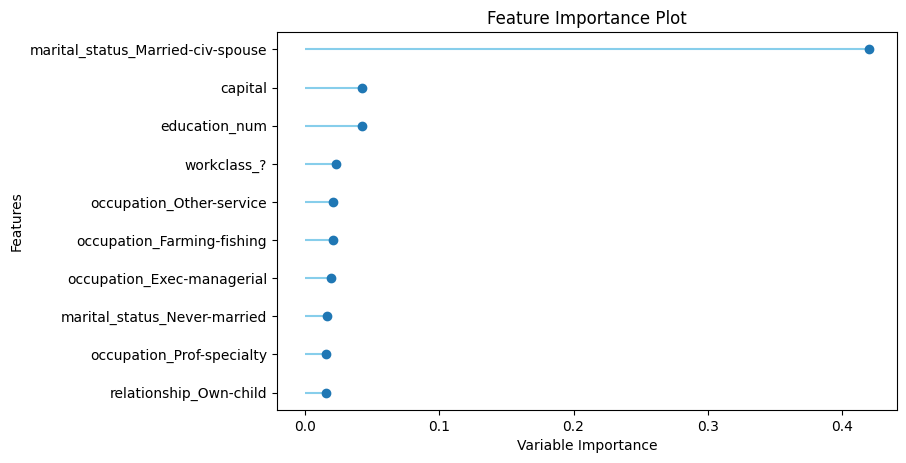

In [23]:
plot_model(estimator = xgboost, plot = 'feature')

In [24]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8637,0.9205,0.6246,0.7689,0.6893,0.6032,0.6086
1,0.8614,0.9161,0.6602,0.7391,0.6974,0.6079,0.6095
2,0.8575,0.9142,0.6408,0.7361,0.6851,0.5936,0.5960
3,0.8574,0.9151,0.6299,0.7405,0.6807,0.5896,0.5928
4,0.8503,0.9101,0.6052,0.7305,0.6619,0.5669,0.5710
5,0.8660,0.9294,0.6505,0.7614,0.7016,0.6158,0.6190
6,0.8770,0.9359,0.6505,0.8040,0.7191,0.6415,0.6474
7,0.8629,0.9193,0.6343,0.7597,0.6914,0.6041,0.6082
8,0.8683,0.9250,0.6472,0.7722,0.7042,0.6204,0.6244
9,0.8738,0.9206,0.6731,0.7761,0.7210,0.6400,0.6427


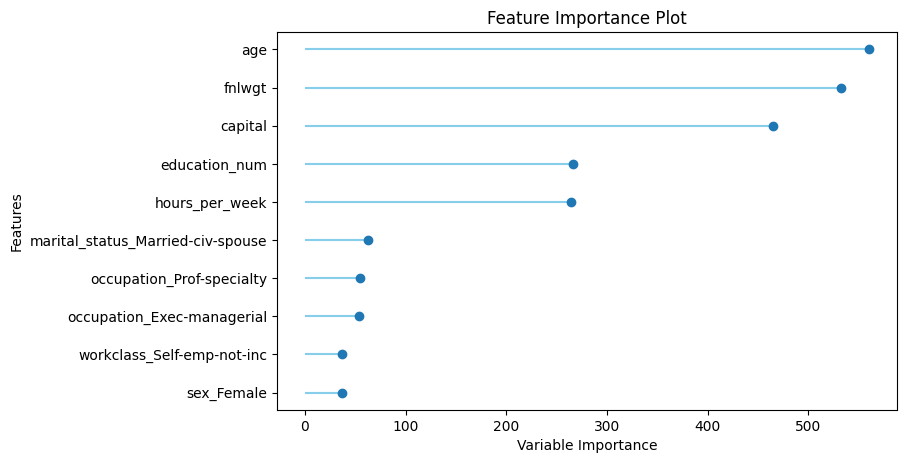

In [25]:
plot_model(estimator = lightgbm, plot = 'feature')